# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [100]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [19]:
import pandas as pd
import numpy as np
signames=pd.read_csv('signnames.csv',delimiter=',')

In [20]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

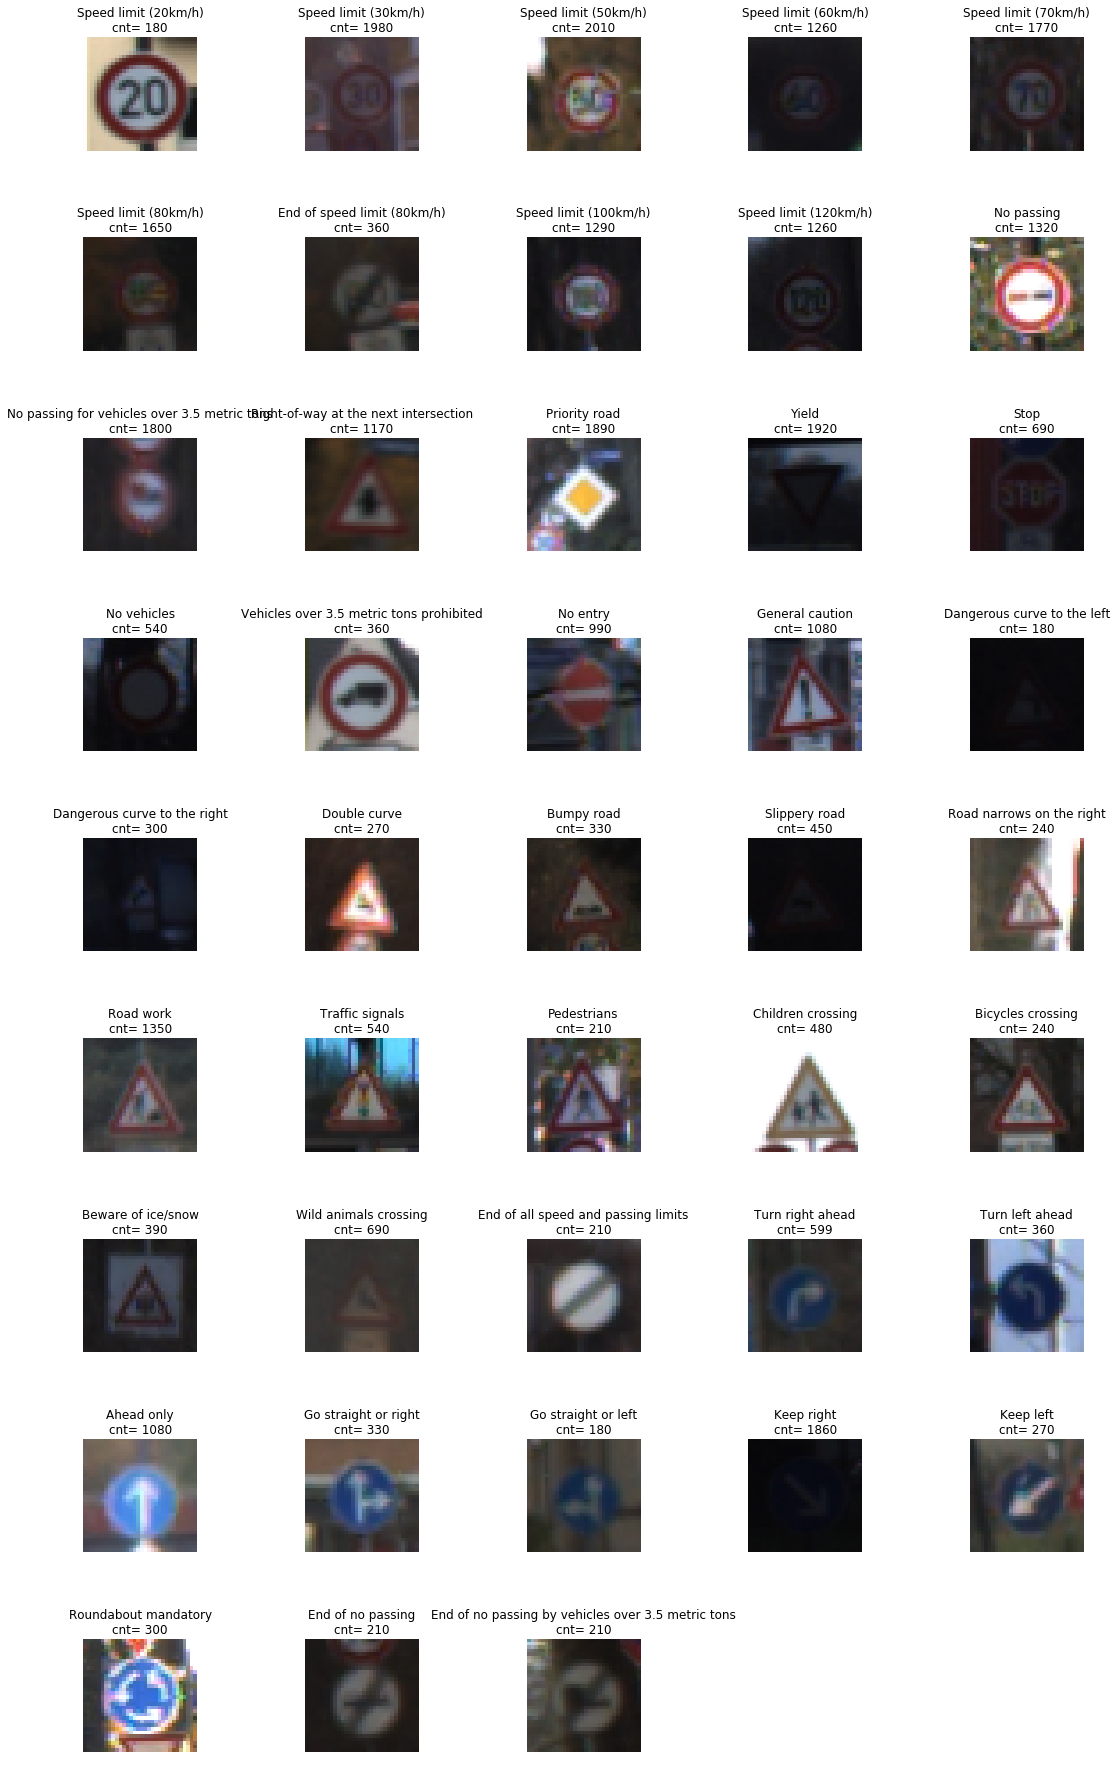

In [30]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline

import matplotlib.pyplot as plt
import cv2

n_row=5

f, ax = plt.subplots(int(n_classes/n_row)+1, n_row)

f.set_figheight(25)
f.set_figwidth(15)

#turn off axis
for a in ax:
    for b in a:
        b.axis('off') 

#for all signames draw an image
for val, name in signames.values:
    q=np.where(y_train==val)[0]
    now=ax[int(val/5)][val%5]
    
    now.set_title('%s\ncnt= %d' %(name,len(q)))
    now.imshow(X_train[q[0]])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.axis('off') 
plt.show()    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
import cv2
normalizer = lambda x: (x-x.mean())/x.std()

def preprocess(X):
    #grayscale 
    X=X.mean(axis=3).reshape((X.shape[0], X.shape[1], X.shape[2],1))
    
    #normalize
    return np.array(list(map(normalizer,X)))

In [82]:
import cv2
#normalizer = lambda x: (x-x.mean())/x.std()

def preprocess_v2(X, verbose=False):
    
    #if verboset
    if verbose:
        f, ax = plt.subplots(1, 5)
        f.set_figheight(5)
        f.set_figwidth(15)
        for a in ax:
            a.axis('off')
        ax[0].set_title('original')
        ax[0].imshow(X)
    
    #change color space
    X=cv2.normalize(X,np.zeros((32,32,3)),alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    if verbose:
        ax[1].set_title('Normalize')
        ax[1].imshow(X)
    
    
    
    X=cv2.cvtColor(X, cv2.COLOR_BGR2YUV).astype(np.float)
    
    for i in range(3):
        X[:,:,i]-=X[:,:,i].mean()
    
    
    if verbose:
        for i in range(3):
            
            ax[i+2].set_title('Channel %s' % 'YUV'[i])
            ax[i+2].imshow(X[:,:,i],cmap="gray")
        plt.show()
    return X

# example of images preprocessing
1) normalize <br>
2) convert to YUV<br>
3) normalize for y channel<br>

In [83]:
tmp[:,1].mean()

-0.0055247062649262562

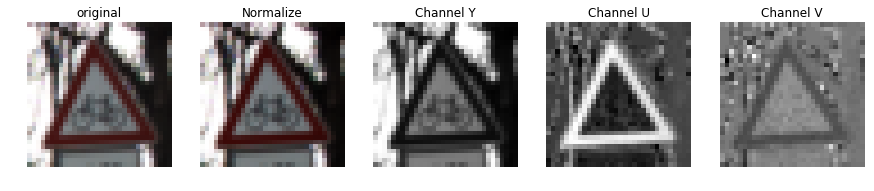

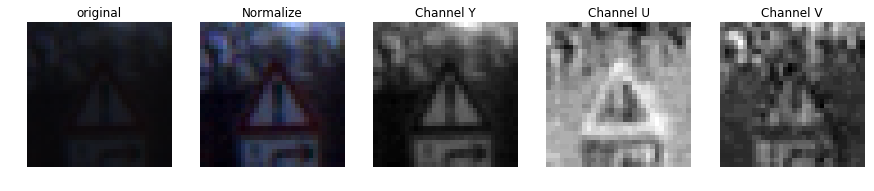

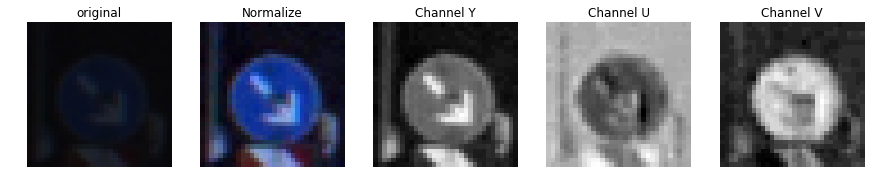

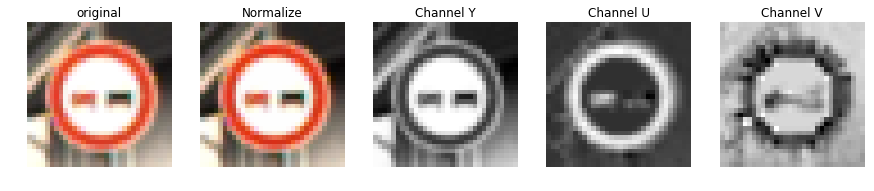

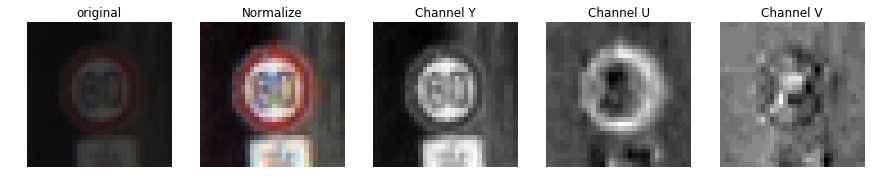

In [84]:
#show in random examples
for i in np.random.choice(len(X_train),5,replace=False):
    tmp=preprocess_v2(X_train[i],verbose=True)

### Now we generate "Jittered dataset" like in paper - making random rotations and affine transformations

In [101]:
from itertools import product

def rotate(img, angle):
    """
    function to rotate 10 or -10
    """
    
    #no need to rotate
    if angle==0:
        return img
    
    rows,cols = img.shape[0],img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    tmp=np.zeros_like(img)
    for i in range(img.shape[2]):
        tmp[:,:,i]=cv2.warpAffine(img[:,:,i],M,(cols,rows))
    
    return tmp

def resize(img, side, where_cut):
    """
    Function for resize and crop image
    """
    tmp=None
    
    #if no need to resize
    if side==0:
        return img
    
    if side==1:
        tmp=cv2.resize(img,None,fx=1.2, fy=1, interpolation = cv2.INTER_CUBIC)[:32,:32]
    if side==-1:
        tmp=cv2.resize(img,None,fx=1, fy=1.2, interpolation = cv2.INTER_CUBIC)[:32,:32]
        
    if where_cut==1:
        return tmp[-32:,-32:]
    return tmp[:32,:32]

##todo rotate->resize and resize->rotate
def get_resized_and_rotated(img, cnt=-1):
    """
    get fixed number of resized and rotated images
    """
    all_variants=np.array([a for a in product([-10,0,10],[1,0,-1],[1,-1]) if not (a[0]==0 and a[1]==0)])
    #if needed only samples
    if cnt>0:
        all_variants=all_variants[np.random.choice(len(all_variants),cnt,replace=False)]
    
    return np.array([rotate(resize(img,a[1],a[2]),a[0]) for a in all_variants])

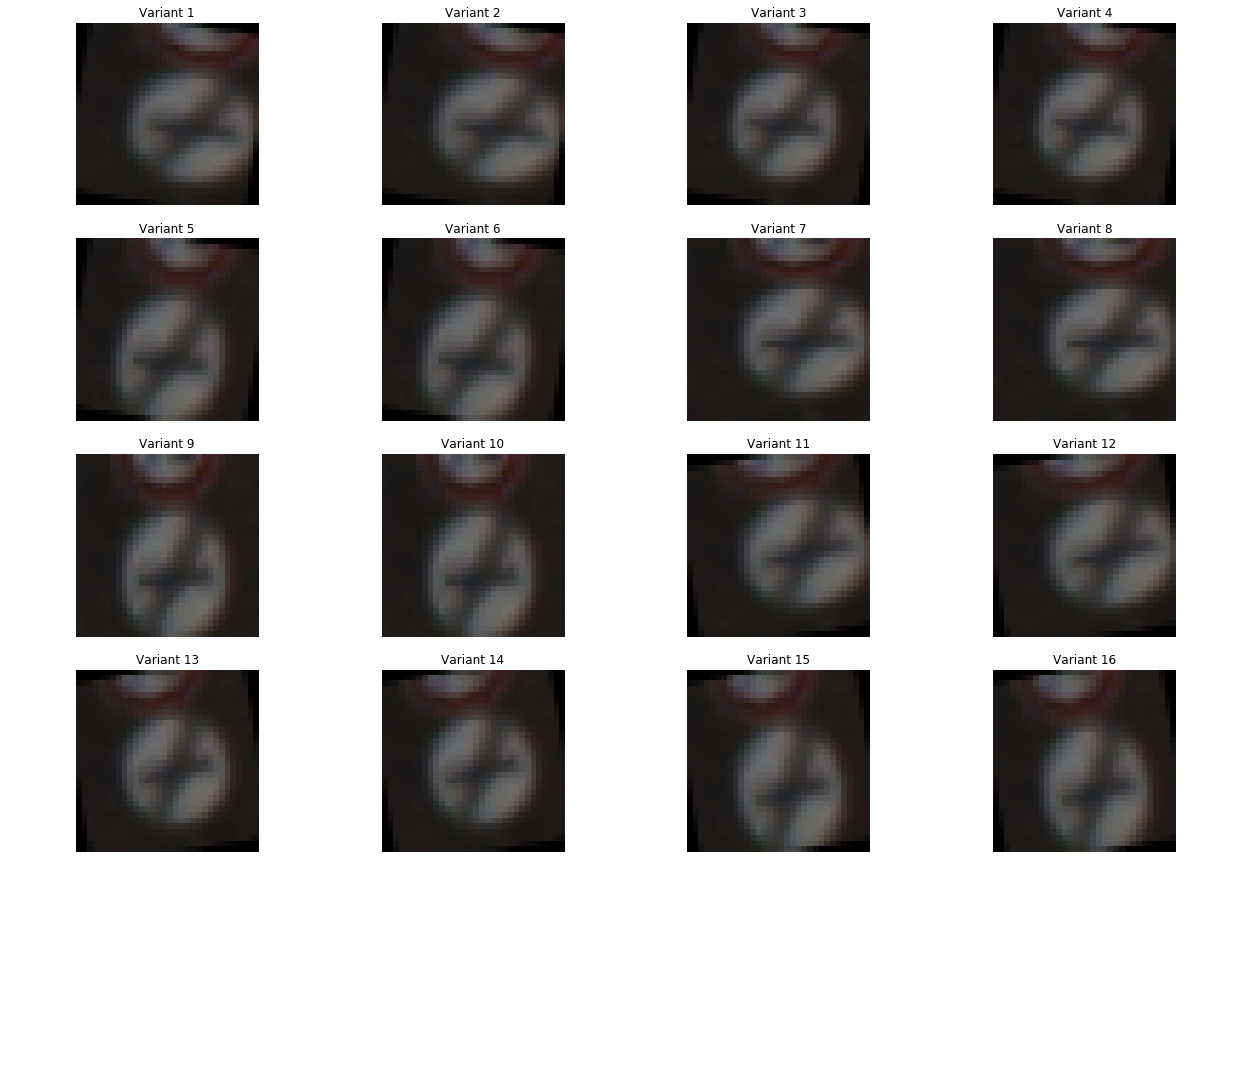

In [115]:
#example of random transformations
all_variants=get_resized_and_rotated(X_train[0], cnt=-1)

n_row=4

f, ax = plt.subplots(int(len(all_variants)/n_row)+1, n_row)

f.set_figheight(15)
f.set_figwidth(4*int(len(all_variants)/n_row)+1)

#turn off axis
for a in ax:
    for b in a:
        b.axis('off') 

#for all signames draw an image
for i,img in enumerate(all_variants):
    now=ax[int(i/n_row)][i%n_row]
    now.set_title('Variant %d' % (i+1))
    now.imshow(img)

plt.axis('off') 
plt.show()    

In [99]:
X_train=np.array([preprocess_v2(a) for a in X_train])
X_valid=np.array([preprocess_v2(a) for a in X_valid])
X_test=np.array([preprocess_v2(a) for a in X_test])



### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (conv1, conv2,  logits)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [15]:
rate = 0.001

conv1, conv2, logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [22]:
from tqdm import tqdm_notebook

In [24]:
EPOCHS = 100
BATCH_SIZE = 128
from sklearn.utils import shuffle
import datetime
valid_acc=np.zeros(EPOCHS, dtype=np.float)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in tqdm_notebook(range(EPOCHS)):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        valid_acc[i]=validation_accuracy
        print("EPOCH {} ...".format(i+1), datetime.datetime.now())
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...


EPOCH 1 ... 2017-03-26 00:22:54.876690
Validation Accuracy = 0.491

EPOCH 2 ... 2017-03-26 00:23:17.253609
Validation Accuracy = 0.635

EPOCH 3 ... 2017-03-26 00:23:39.633702
Validation Accuracy = 0.709

EPOCH 4 ... 2017-03-26 00:24:02.287266
Validation Accuracy = 0.764

EPOCH 5 ... 2017-03-26 00:24:24.595885
Validation Accuracy = 0.788

EPOCH 6 ... 2017-03-26 00:24:47.078207
Validation Accuracy = 0.796

EPOCH 7 ... 2017-03-26 00:25:09.773932
Validation Accuracy = 0.805

EPOCH 8 ... 2017-03-26 00:25:32.174065
Validation Accuracy = 0.811

EPOCH 9 ... 2017-03-26 00:25:54.606008
Validation Accuracy = 0.817

EPOCH 10 ... 2017-03-26 00:26:16.889236
Validation Accuracy = 0.830

EPOCH 11 ... 2017-03-26 00:26:39.387215
Validation Accuracy = 0.831

EPOCH 12 ... 2017-03-26 00:27:01.793050
Validation Accuracy = 0.848

EPOCH 13 ... 2017-03-26 00:27:24.529837
Validation Accuracy = 0.841

EPOCH 14 ... 2017-03-26 00:27:47.122007
Validation Accuracy = 0.845

EPOCH 15 ... 2017-03-26 00:28

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.894


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [105]:
from wget import download
from PIL import Image
import os

real=False

if real:
    os.system('rm *.jpg')

image_urls=['https://upload.wikimedia.org/wikipedia/commons/f/f9/STOP_sign.jpg',\
            'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381091?s=170667a',\
            'http://media.gettyimages.com/photos/speed-limit-on-country-road-picture-id503368326?s=170667a',\
            'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381017?s=170667a',\
            'http://media.gettyimages.com/photos/german-priority-sign-picture-id157296103?s=170667a'
           ]
if real:
    for i,a in enumerate(image_urls):
        download(a,out='%d.jpg'%i)

In [106]:
crops=[(0,0,1389,1389),(0,0,359,359),(100,0,100+338,338),(0,0,359,359),(0,30,341,30+341)]

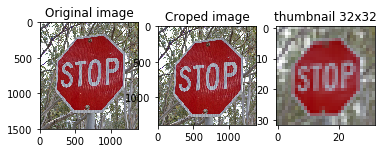

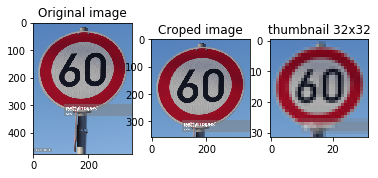

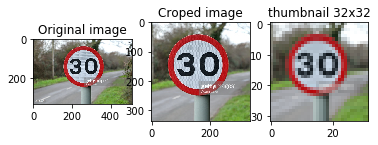

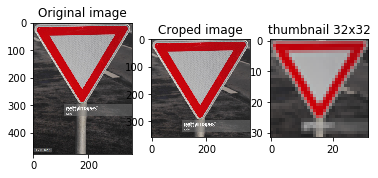

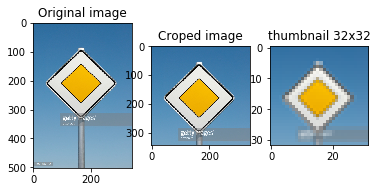

In [107]:
for_test=np.empty((len(image_urls),32,32,3), dtype=np.uint8)

for i in range(len(image_urls)):
    image=Image.open('%d.jpg' %i)
    #print (image.size)
    f, (ax1, ax2,ax3) = plt.subplots(1, 3)
    ax1.imshow(image)
    ax1.set_title('Original image')
    
    
    image=image.crop(crops[i])
    ax2.imshow(image)
    ax2.set_title('Croped image')
    
    image.thumbnail((32,32))
    ax3.imshow(image)
    ax3.set_title('thumbnail 32x32')
    plt.show()
    
    for_test[i]=image

### Predict the Sign Type for Each Image

In [111]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

preprocessed=np.array([preprocess_v2(a) for a in for_test])

In [112]:
#get top-5 predictions
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits),k=5), feed_dict={x: preprocessed})
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

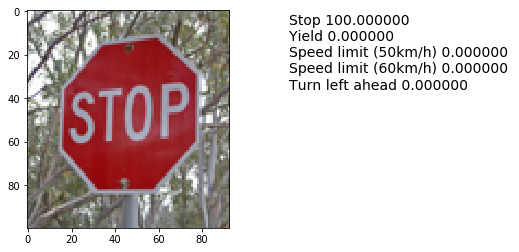

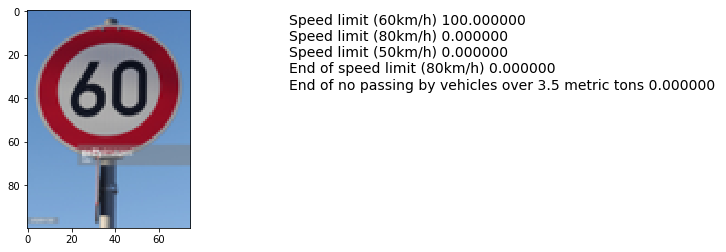

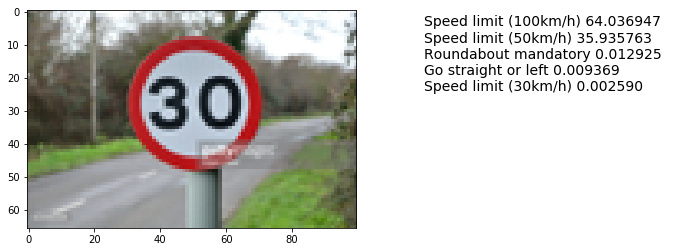

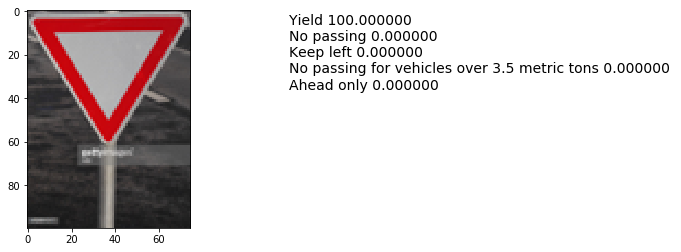

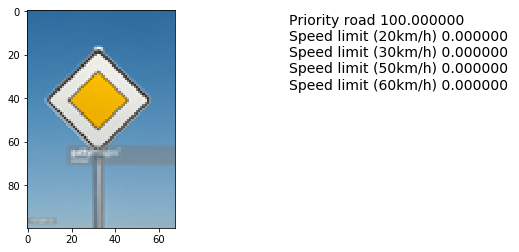

In [113]:
for i in range(5):
    image=Image.open('%d.jpg' %i)
    image.thumbnail((100,100))
    
    inds=top_k.indices[i]
    text=''
    for ind,prob in zip (top_k.indices[i], top_k.values[i]):
        text+='%s %f \n' % (signames.values[ind][1], prob*100)
    
    #f, (ax1, ax2) = plt.subplots(1, 2)
    plt.text(120, 0.95, text,  fontsize=14,
        verticalalignment='top')
    plt.imshow(image)
    
    
    #plt.title('Image %d, width=%d, height=%d', (i, image.size[0],image.size[1]))
    plt.show()
    
    

### Analyze Performance

# Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# 4/5 predicted correctly -> accurancy in 80%

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [131]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(real_image, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation_all = tf_activation.eval(session=sess,feed_dict={x : image_input})
    for i in range(len(activation_all)):
        activation=activation_all[i:(i+2),:,:,:]
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        plt.subplot(6,8, 1)
        plt.imshow(real_image[i])
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+2) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        plt.show()

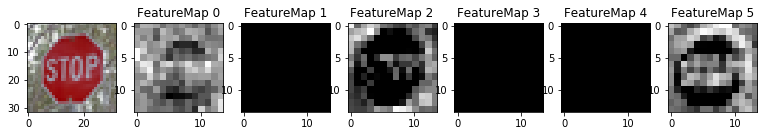

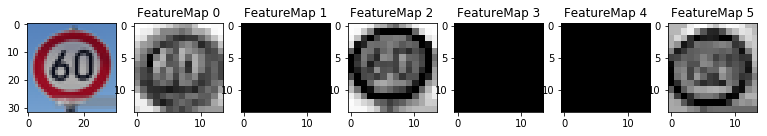

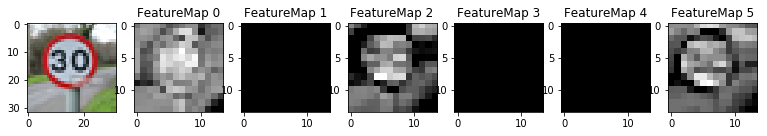

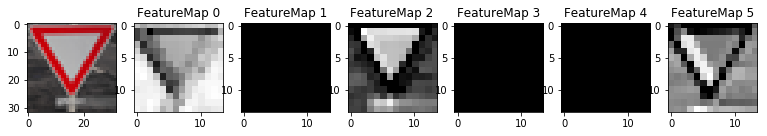

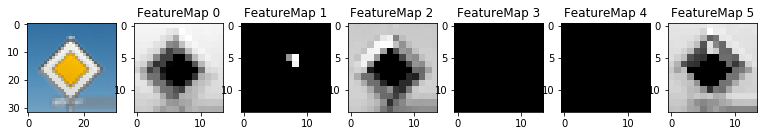

In [132]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(for_test, preprocessed,conv1)

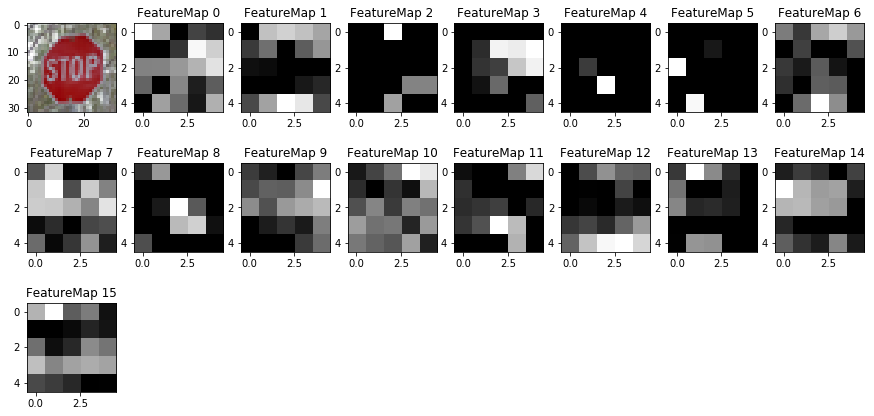

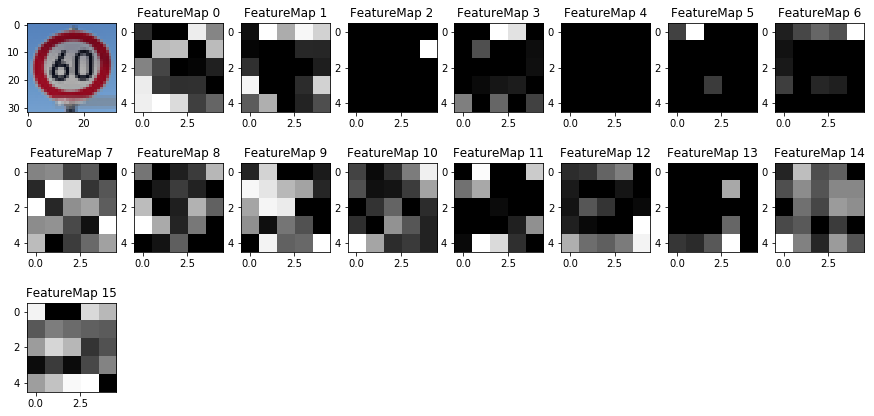

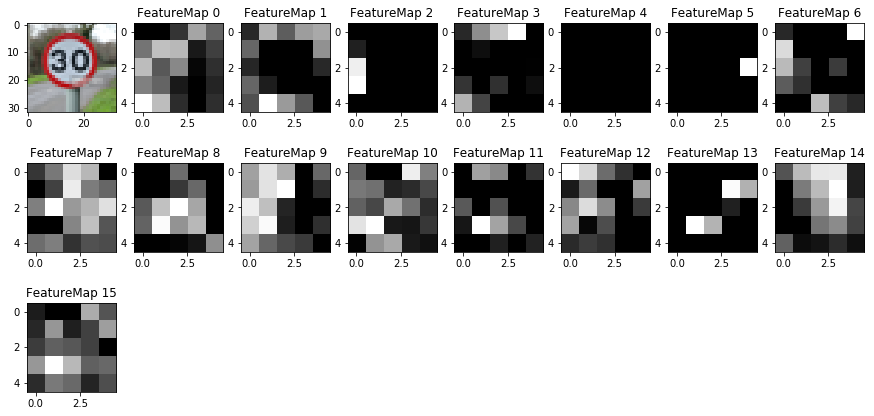

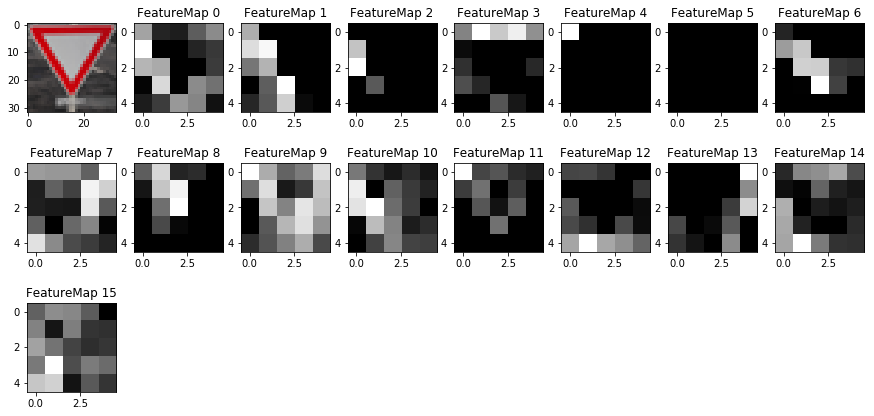

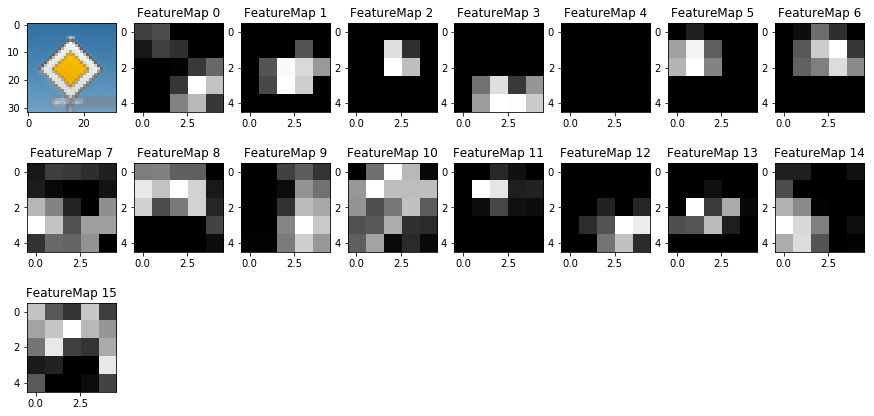

In [133]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(for_test, preprocessed,conv2)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 